# Sarcasm Detection

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## Install `Tensorflow2.0` 

In [1]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl


## Get Required Files from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Set your project path 
import os

project_path = '/content/drive/My Drive/NLP_sarcasm_detector'
try:  
    os.chdir(project_path)
    print("Directory changed to Project folder")
except OSError:
    print("Can't change the Current Working Directory")

Directory changed to Project folder


#**## Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [4]:
import pandas as pd
df = pd.read_json(project_path+'/Data/Sarcasm_Headlines_Dataset.json' ,lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [5]:
df = df.drop(['article_link'], axis = 1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [6]:
df['len'] = df['headline'].apply(lambda x: len(x.split(" ")))
df.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [7]:
maxlen=max(df['len'])
print(maxlen)

39


#**## Modelling**

## Import required modules required for modelling.

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model. ( 2 marks)

In [0]:
max_features = 10000
maxlen = maxlen
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))

# Define X and y for your model.

In [11]:
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  307  678 3336 2297   47  381 2575    5 2576 8433]
Number of Labels:  26709
0


## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [12]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29657


#**## Word Embedding**

## Get Glove Word Embeddings

In [0]:
glove_file = project_path + "/Data/glove.6B.zip"

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in training docs

In [16]:
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [17]:
import keras.backend as K
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Embedding(num_words, embedding_size,weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128,return_sequences = True)))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy',precision,recall])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         5931400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         336896    
_________________________________________________________________
dense (Dense)                (None, None, 40)          10280     
_________________________________________________________________
dropout (Dropout)            (None, None, 40)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 20)          820       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           2

# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [20]:
import time
batch_size = 500
epochs = 5

start = time.clock()
history = model.fit(X , y, epochs=epochs, batch_size=batch_size, validation_split=0.2)
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 59s 3ms/sample - loss: 0.6099 - accuracy: 0.6595 - precision: 0.6266 - recall: 17.7842 - val_loss: 0.4665 - val_accuracy: 0.7985 - val_precision: 0.8016 - val_recall: 27.7333
Epoch 2/5
21367/21367 [==============================] - 55s 3ms/sample - loss: 0.4026 - accuracy: 0.8395 - precision: 0.8172 - recall: 32.0284 - val_loss: 0.3589 - val_accuracy: 0.8443 - val_precision: 0.8402 - val_recall: 30.8255
Epoch 3/5
21367/21367 [==============================] - 54s 3ms/sample - loss: 0.2793 - accuracy: 0.8991 - precision: 0.8859 - recall: 34.5338 - val_loss: 0.3394 - val_accuracy: 0.8550 - val_precision: 0.8432 - val_recall: 31.9092
Epoch 4/5
21367/21367 [==============================] - 55s 3ms/sample - loss: 0.2098 - accuracy: 0.9277 - precision: 0.9166 - recall: 35.8772 - val_loss: 0.3805 - val_accuracy: 0.8607 - val_precision: 0.8510 - val_recall: 32.0879
Epoch 5/5
21367/21367 [

In [21]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


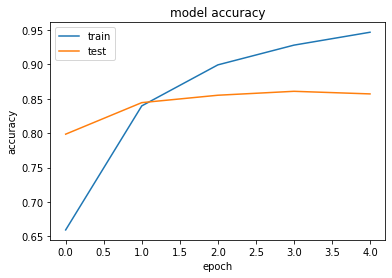

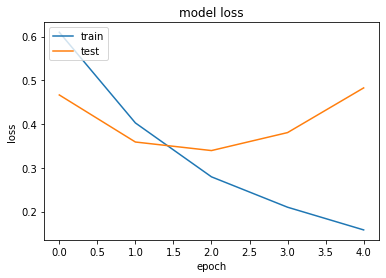

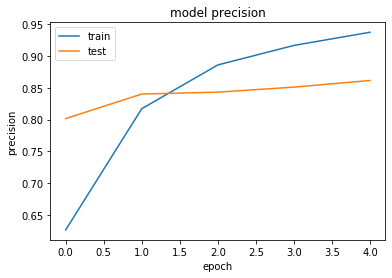

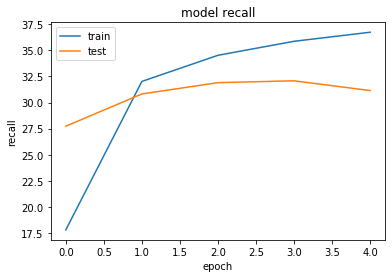

In [22]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model.layers # get all layers from model

In [24]:
# Validation accuracy
accuracy = history.history['val_accuracy'][epochs-1]
print('Validation Accuracy: %.2f%%' %(accuracy*100))

Validation Accuracy: 85.69%


# Checking the model with some user given data
Output = 1 : Sarcasm ,
Output = 0 : Not a Sarcasm

# Example 1  --  Verifying Sarcasm
Alex just wants wife to listen, not come up with suggestions

In [25]:
# Example 1  -- Sarcasm
# Optional code to verify sarcasm
test = ["Alex just wants wife to listen, not come up with suggestions"]
# Vectoring the sample by the pre-fitted tokenizer instance
test_seq = tokenizer.texts_to_sequences(test)
# padding the sample to have exactly the same shape as embedding input
test_pad = pad_sequences(test_seq, maxlen=maxlen)
print(test_pad) 
sarcasm = model.predict_classes(test_pad)[0][0][0]
print(sarcasm)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 3211   35  223  399    1 1831   28  318   21    9]]
1


Result - Correctly identified as sarcasm

# Example 2  --  Verifying Sarcasm
She generally gave herself very good advice, (though she very seldom followed it).

In [26]:
# Example 2  -- Sarcasm
# Optional code to verify sarcasm
test = ["She generally gave herself very good advice, (though she very seldom followed it)."]
# Vectoring the sample by the pre-fitted tokenizer instance
test_seq = tokenizer.texts_to_sequences(test)
# padding the sample to have exactly the same shape as embedding input
test_pad = pad_sequences(test_seq, maxlen=maxlen)
print(test_pad) 
sarcasm = model.predict_classes(test_pad)[0][0][0]
print(sarcasm)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   142 1062 1762  420  133  804 6766  142  420 7339   26]]
1


Result - Correctly identified as sarcasm

# Example 3  --  Verifying Sarcasm
Nothing stinks like a pile of unpublished writing.

In [27]:
# Example 3 -- Sarcasm
# Optional code to verify sarcasm
test = ["Nothing stinks like a pile of unpublished writing."]
# Vectoring the sample by the pre-fitted tokenizer instance
test_seq = tokenizer.texts_to_sequences(test)
# padding the sample to have exactly the same shape as embedding input
test_pad = pad_sequences(test_seq, maxlen=maxlen)
print(test_pad) 
sarcasm = model.predict_classes(test_pad)[0][0][0]
print(sarcasm)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  560   57    6 2888    2 9305 1316]]
1


Result - Correctly identified as sarcasm

# Example 4  --  Verifying Not a Sarcasm
This is a nice book

In [28]:
# Example 4 -- Not a sarcasm
# Optional code to verify sarcasm
test = ["This is a nice book"]
# Vectoring the sample by the pre-fitted tokenizer instance
test_seq = tokenizer.texts_to_sequences(test)
# padding the sample to have exactly the same shape as embedding input
test_pad = pad_sequences(test_seq, maxlen=maxlen)
print(test_pad) 
sarcasm = model.predict_classes(test_pad)[0][0][0]
print(sarcasm)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   18   10    6 1202  315]]
0


Result - Correctly identified as not a sarcasm

**Conclusion**

The sarcasm detection model was built successfully with an accuracy of 85.69%. However, from the accuracy,recall,precision and loss graphs it is clear that as epochs increases although the model performing well on training set but the performance decreases as the loss increases in the test set. Hence, to get good result in test set and prevent the model from getting overfitted, it is required that we have more data with lot of variations, so that we can train our model better. At the end we cheched our model with some user given data , and found that the model is able to identify them correctly.